In [1]:
import os
import sys
import pandas as pd
import numpy as np
import zipfile
import datetime
import matplotlib.pyplot as plt
from pylab import mpl
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
#mpl.rcParams['font.sans-serif'] = u'PingFang'    # 指定默认字体:解决plot不能显示中文问题 
mpl.rcParams['axes.unicode_minus'] = False 



# 读取压缩文件

In [3]:
file_list = []
for i in os.walk('.'):
    file_list.extend(i)
for _ in file_list[2]:
    if 'zip' in './'+_:
        with zipfile.ZipFile('./'+_) as f:
            f.extract(f.namelist()[0])#将文件读取至当前目录下
            #f.read(f.namelist()[0])
        

# 看看数据大概是什么样的 

In [122]:
temp = all_data[all_data['city'] == '广州']
#temp.to_csv('err.csv',encoding = 'gbk')
temp2 = all_data[718743:718750]
print(temp2)

target_cities = all_data[(all_data['city']== '北京')|(all_data['city']== '上海')|(all_data['city']== '广州')|(all_data['city']== '深圳')]
target_cities.to_csv('target_cities.csv', encoding = 'gbk')

                       time city   site    aqi level      primarypollutant  \
718743  2017-12-21 22:00:00   广州     36     20   市五中                     _   
718744  2017-12-21 22:00:00   广州      _  广东商学院   108                  轻度污染   
718745  2017-12-21 22:00:00   广州     20  市八十六中   142                  轻度污染   
718746  2017-12-21 22:00:00   广州     18   番禺中学     _                     _   
718747  2017-12-21 22:00:00   广州   花都师范     90     良  颗粒物(PM10)细颗粒物(PM2.5)   
718748  2017-12-21 22:00:00   广州   市监测站     90     良             颗粒物(PM10)   
718749  2017-12-21 22:00:00   广州  九龙镇镇龙    128  轻度污染           细颗粒物(PM2.5)   

             pm25 pm10   co  no2 ozone1hour ozone8hour so2  
718743          _    _  167  3.1        175         16  49  
718744  颗粒物(PM10)   68  166  1.3        148          6  38  
718745  颗粒物(PM10)   76  234  2.2        143          8  36  
718746          _  177  2.5  131          5         38  22  
718747         67  129  1.5  121          8         56  25  
718748   

# 数据对齐模块

In [198]:

region = pd.read_csv(r'region1.csv', encoding = 'gb2312')
region.rename(columns = {'Unnamed: 2': 'provin', 'Unnamed: 3' : 'city'}, inplace = True)
region.drop(region.columns[0:2],axis = 1,inplace = True)#删除掉没用的列，注意，此时直接修改的是源文件
region['provin'] = region['provin'].ffill()
count_number = region.dropna()#打印一下数据清洗的结果，接下来删除直辖市,及港澳台地区
count_number = count_number[(count_number['provin']!='北京市')&(count_number['provin']!='天津市')&(count_number['provin']!='重庆市')&(count_number['provin']!='上海市')]
count_number.index = range(0, len(count_number))#修改index值
for i in range(0,343):
    if count_number.ix[i,'city'][-1] == '市':
        count_number.ix[i,'city'] = count_number.ix[i,'city'].rstrip('市')
#接下来使用数据对齐
temp1 = pd.merge(count_number, letmes_cit_ind, how = 'left', on = ['city'])
temp2 = pd.merge(count_number, letmes_cit_ind, how = 'right', on = ['city'])

# 生成器，主要生成数据, 很多cell都使用这个函数

In [2]:
def data_read():
    '''生成器，主要生成数据,
    大量数据清洗的cell都使用这个函数'''
    try:
        for each in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            data_2017 = pd.read_csv(r'../2017-{}.csv'.format(each))
            yield data_2017
    except FileNotFoundError:
        print('this data 2017-{}.csv can not found'.format(each))

# 查看2017年每个月有哪些工作站在正常工作，也正是通过这个函数发现表格中有几个月存在混乱数据。实际上这一年中每个月份的监测站都应该有49个监测站, 但实际上有几个月，监测站数量超过49个。

In [24]:
def let_me_see_sites(cities):
    month_list = []
    i = 1
    for sites in data_read():
        _ = sites[(sites['city'] == cities[0])|(sites['city'] == cities[1])|(sites['city'] == cities[2])|\
              (sites['city'] == cities[3])|(sites['city'] == cities[4])]
        sites_of_month = _.drop_duplicates(subset = ['site'],keep = 'first')
        sites_of_month.to_csv('sites_2017_{}.csv'.format(i), encoding = 'gbk')
        month_list.append(sites_of_month)
        if len(sites_of_month) != 49:
            print('{}月的数据存在问题'.format(i))
        i += 1
    sites = pd.concat(month_list);sites.index  = range(len(sites))
    sites = sites.drop_duplicates(subset = ['site'], keep = 'first')#原来是想把每个月的站点的拼接在一起，然后看一看一共有\
    #哪些站点
    return sites,month_list
let_me_see_sites(['北京','上海','广州','深圳','宜昌'])[0].to_csv('target_sites.csv', encoding = 'gb2312')     

D:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1月的数据存在问题
6月的数据存在问题
7月的数据存在问题
9月的数据存在问题
12月的数据存在问题


# 数据清洗模块
## 读取每个月的数据，按照城市-站点-pm25数值对站点进行选择，不遵循索引规则的数据，一律予以滤除

In [3]:
all_data = pd.read_csv(r'../2017-02.csv')#经检查，这个月的数据是没有问题的，以这个月数据为标尺确定有多少个sites
taget_sites = all_data[(all_data['city']== '北京')|(all_data['city']== '上海')|(all_data['city']== '广州')|(all_data['city']== '深圳')|(all_data['city']== '宜昌')].drop_duplicates(subset = ['site'],keep = 'first')
#taget_sites.to_csv('target_sites.csv', encoding  = 'gbk')
sites_5 = taget_sites['site']
sites_5 = list(sites_5)

D:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
cities = ['北京','上海','广州','深圳','宜昌']
def data_read():
    '''生成器，主要生成数据,
    大量数据清洗的cell都使用这个函数'''
    try:
        for each in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            data_2017 = pd.read_csv(r'../2017-{}.csv'.format(each))
            yield data_2017
    except FileNotFoundError:
        print('this data 2017-{}.csv can not found'.format(each))
        
def clean_data_2017(cities):
    month_list = []
    i = 1
    for city in data_read():
        temp = city[(city['city'] == cities[0])|(city['city'] == cities[1])|(city['city'] == cities[2])|\
              (city['city'] == cities[3])|(city['city'] == cities[4])]
        temp = temp[(temp['site'] == sites_5[0])|(temp['site'] == sites_5[1])|(temp['site'] == sites_5[2])|(temp['site'] == sites_5[3])|(temp['site'] == sites_5[4])|(temp['site'] == sites_5[5])|\
                    (temp['site'] == sites_5[6])|(temp['site'] == sites_5[7])|(temp['site'] == sites_5[8])|(temp['site'] == sites_5[9])|(temp['site'] == sites_5[10])|(temp['site'] == sites_5[11])|\
                    (temp['site'] == sites_5[12])|(temp['site'] == sites_5[13])|(temp['site'] == sites_5[14])|(temp['site'] == sites_5[15])|(temp['site'] == sites_5[16])|(temp['site'] == sites_5[17])|\
                   (temp['site'] == sites_5[18])|(temp['site'] == sites_5[19])|(temp['site'] == sites_5[20])|(temp['site'] == sites_5[21])|(temp['site'] == sites_5[22])|(temp['site'] == sites_5[23])|\
                   (temp['site'] == sites_5[24])|(temp['site'] == sites_5[25])|(temp['site'] == sites_5[26])|(temp['site'] == sites_5[27])|(temp['site'] == sites_5[28])|(temp['site'] == sites_5[29])|\
                   (temp['site'] == sites_5[30])|(temp['site'] == sites_5[31])|(temp['site'] == sites_5[32])|(temp['site'] == sites_5[33])|(temp['site'] == sites_5[34])|(temp['site'] == sites_5[35])|\
                   (temp['site'] == sites_5[36])|(temp['site'] == sites_5[37])|(temp['site'] == sites_5[38])|(temp['site'] == sites_5[39])|(temp['site'] == sites_5[40])|(temp['site'] == sites_5[41])|\
                   (temp['site'] == sites_5[42])|(temp['site'] == sites_5[43])|(temp['site'] == sites_5[44])|(temp['site'] == sites_5[45])|(temp['site'] == sites_5[46])|(temp['site'] == sites_5[47])|\
                   (temp['site'] == sites_5[48])]
        yield temp
def city_stat(kind_of_stat,level_sel = 1):
    df_list = []
    for each in clean_data_2017(cities):
        '''每次循环产生一个31行30列的数据，5*6（五个城市，六个统计指标，5个5个一循环，循环六次）'''
        each.time = pd.to_datetime(each.time)
        each[['pm25','pm10']] = each[['pm25','pm10']].apply(pd.to_numeric, errors = 'coerce')#将字符串类型的一列数据转化为数值型
        each = each.dropna()#是直接在原dataframe上进行操作，直接删掉NaN
        citygroupby_day = each.groupby([each.time.dt.day, 'city'])
        citygroupby_month = each.groupby([each.time.dt.month, 'city'])
        if kind_of_stat == 'day':
            df1 = citygroupby_day.pm25.median().unstack(level = level_sel)#将多层次的series数据，用unstack转化为dataframe类型
            df2 = citygroupby_day.pm25.mean().unstack(level = level_sel)
            df3 = citygroupby_day.pm25.std().unstack(level = level_sel)
            df4 = citygroupby_day.pm25.var().unstack(level = level_sel)
            df5 = citygroupby_day.pm25.min().unstack(level = level_sel)
            df6 = citygroupby_day.pm25.max().unstack(level = level_sel)
        if kind_of_stat == 'month':
            df1 = citygroupby_month.pm25.median().unstack(level = level_sel)
            df2 = citygroupby_month.pm25.mean().unstack(level = level_sel)
            df3 = citygroupby_month.pm25.std().unstack(level = level_sel)
            df4 = citygroupby_month.pm25.var().unstack(level = level_sel)
            df5 = citygroupby_month.pm25.min().unstack(level = level_sel)
            df6 = citygroupby_month.pm25.max().unstack(level = level_sel)
        df_mon = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1,join_axes=[df6.index])#默认是纵向拼接，axis= 0
        df_list.append(df_mon)
    one_year_data = pd.concat(df_list)
    one_year_data.index = range(len(one_year_data))
    
    return one_year_data, df_list

      
def site_stat( kind_of_stat,level_sel,):
    '参数选择，level_sel为0时，监测站为index, 为1时，监测站为column'
    month_index = []
    for each in clean_data_2017(cities):
        each.time = pd.to_datetime(each.time)
        each[['pm25','pm10']] = each[['pm25','pm10']].apply(pd.to_numeric, errors = 'coerce')
        each.dropna()
        groupby_data_day = each.groupby([each.time.dt.day, 'site'])
        groupby_data_week = each.groupby([each.time.dt.week, 'site'])
        groupby_data_month = each.groupby([each.time.dt.month, 'site'])
        if kind_of_stat == 'day':
            df1 = groupby_data_day.pm25.median().unstack(level = level_sel)
            df2 = groupby_data_day.pm25.mean().unstack(level = level_sel)
            df3 = groupby_data_day.pm25.std().unstack(level = level_sel)
            df4 = groupby_data_day.pm25.var().unstack(level = level_sel)
            df5 = groupby_data_day.pm25.min().unstack(level = level_sel)
            df6 = groupby_data_day.pm25.max().unstack(level = level_sel)
        '''groupby_data_week.pm25.median().unstack()
        groupby_data_week.pm25.mean().unstack()
        groupby_data_week.pm25.std().unstack()
        groupby_data_week.pm25.var().unstack()
        groupby_data_week.pm25.min().unstack()
        print(groupby_data_week.pm25.max().unstack())'''
        if kind_of_stat == 'month':
            df1 = groupby_data_month.pm25.median().unstack(level = level_sel)
            df2 = groupby_data_month.pm25.mean().unstack(level = level_sel)
            df3 = groupby_data_month.pm25.std().unstack(level =level_sel)
            df4 = groupby_data_month.pm25.var().unstack(level = level_sel)
            df5 = groupby_data_month.pm25.min().unstack(level = level_sel)
            df6 = groupby_data_month.pm25.max().unstack(level = level_sel)

            
        df_mon = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1-level_sel,)
        month_index.append(df_mon)
    stat_outcome = pd.concat(month_index, axis = 1- level_sel,)
    return stat_outcome

'''stat_month.to_csv('month_gb.csv',encoding = 'gb2312')
stat_month.to_csv('month_gbk.csv',encoding = 'gbk')
stat_month.to_csv('month_utf.csv',encoding = 'utf-8')'''
data_for_drawing_day = city_stat('day')[0]#这行语句用来绘制图像
data_for_drawing_year = city_stat('month')[0]

stacked_data_for_drawing_data = city_stat('day')[1]

    
    

D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:90: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:91: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:93: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


# 经推测，清洗后的数据中，每个月所有工作站都保证了正常工作

In [257]:
coor_of_some_sites = pd.read_csv('coord_cs.csv',encoding = 'gb2312')
coor_of_some_sites.columns = ['prov', 'city', 'site', 'latitu','longti']#给数据重新命名
coor_of_5 = coor_of_some_sites[(coor_of_some_sites['city'] == '北京')|(coor_of_some_sites['city'] == '上海')|\
(coor_of_some_sites['city']== '广州')|(coor_of_some_sites['city'] == '深圳')|(coor_of_some_sites['city'] == '宜昌')]
for each in clean_data_2017(cities):
    each = each.drop_duplicates(subset = ['site'], keep = 'first')#drop_duplicates 和drop_na不一样，他并不是直接修改原dateframe，
    #而是生成一份拷贝。
    merge_data_right = pd.merge(each, coor_of_5,how = 'left', on = ['site'])
#merge_data_right.to_csv('data_coor_right.csv', encoding = 'gbk')
    #print(merge_data_right)

/Users/pro/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 拼接坐标cell 

In [244]:
coor_of_some_sites = pd.read_csv('coord_cs.csv',encoding = 'gb2312')
coor_of_some_sites.columns = ['prov', 'city', 'site', 'latitu','longti']#给数据重新命名
coor_of_5 = coor_of_some_sites[(coor_of_some_sites['city'] == '北京')|(coor_of_some_sites['city'] == '上海')|\
(coor_of_some_sites['city']== '广州')|(coor_of_some_sites['city'] == '深圳')|(coor_of_some_sites['city'] == '宜昌')]
stat_month['site'] = stat_month.index

stat_month = pd.merge(stat_month, coor_of_5,how = 'left', on = ['site'])
stat_month.to_csv('month_gb.csv',encoding = 'gb2312')
stat_month.to_csv('month_gbk.csv',encoding = 'gbk')
stat_month.to_csv('month_utf.csv',encoding = 'utf-8')


# 数据可视化模块

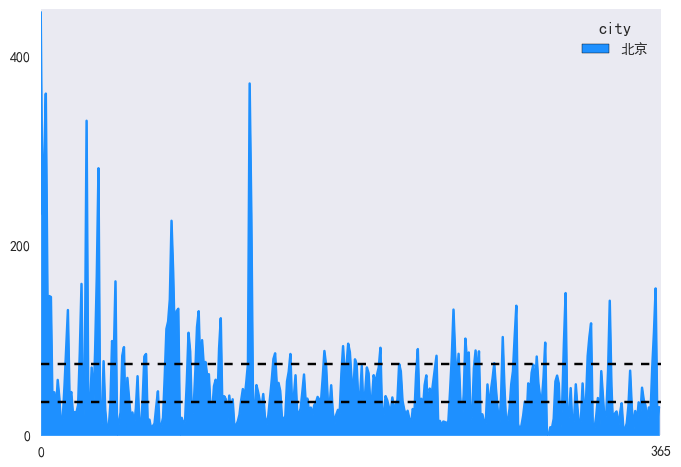

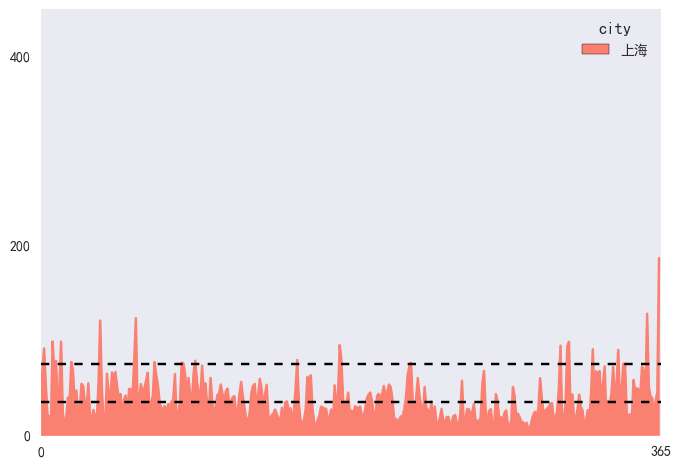

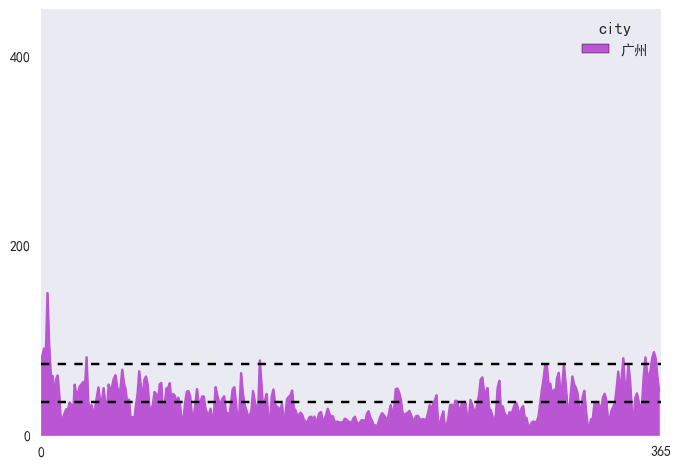

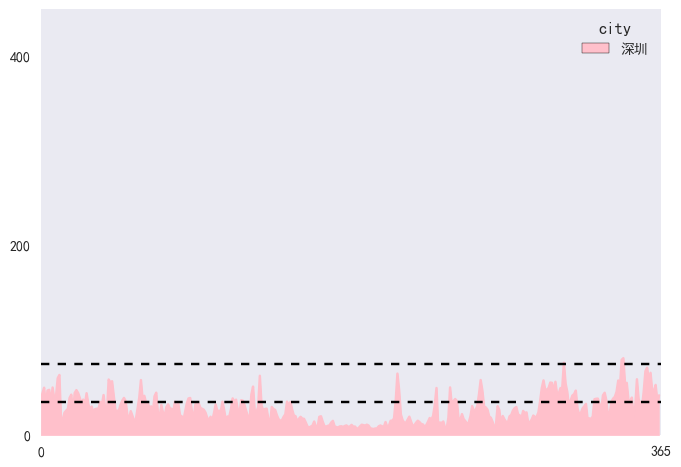

In [145]:
plt.figure(1)
ax = plt.subplot()
data_for_drawing_day['北京'].iloc[:,[1]].plot(kind = 'area',ax = ax,color = '#1E90FF')
plt.xlim([0,365]);plt.xticks([0,365]);plt.ylim([0,450]);plt.yticks([0,200,400])
plt.axhline(35,ls = '--', color = 'black')
plt.axhline(75,ls = '--', color = 'black')
plt.grid('off')

plt.figure(2)
ax = plt.subplot()
data_for_drawing_day['上海'].iloc[:,[1]].plot(kind = 'area',ax = ax,color =  '#FA8072')
plt.xlim([0,365]);plt.xticks([0,365]);plt.ylim([0,450]);plt.yticks([0,200,400])
plt.axhline(35,ls = '--', color = 'black')
plt.axhline(75,ls = '--', color = 'black')
plt.grid('off')

plt.figure(3)
ax = plt.subplot()
data_for_drawing_day['广州'].iloc[:,[1]].plot(kind = 'area',ax = ax,color = '#BA55D3')
plt.xlim([0,365]);plt.xticks([0,365]);plt.ylim([0,450]);plt.yticks([0,200,400])
plt.axhline(35,ls = '--', color = 'black')
plt.axhline(75,ls = '--', color = 'black')
plt.grid('off')

plt.figure(4)
ax = plt.subplot()
data_for_drawing_day['深圳'].iloc[:,[1]].plot(kind = 'area',ax = ax,color = '#FFC0CB')
plt.xlim([0,365]);plt.xticks([0,365]);plt.ylim([0,450]);plt.yticks([0,200,400])
plt.axhline(35,ls = '--', color = 'black')
plt.axhline(75,ls = '--', color = 'black')
plt.grid('off')

plt.show()

##  PM2.5浓度可划分为6个等级，即<font color = '#61de2a'>优</font>（0~35 μg/m3），<font color = '#b8ffb8'>良</font>（35~75 μg/m3），<font color = '#eaf786'>轻度污染</font>,（75~115 μg/m3），<font color = '#ffb5a1'>中度污染</font>（115~150 μg/m3），<font color = 'orangered'>重度污染</font>（150~250 μg/m3），<font color = 'maroon'>严重污染</font>（250~500 μg/m3）,按照此分级方法，对每个城市每个月，6类空气等级的占比，进行一个堆叠直方图可视化。

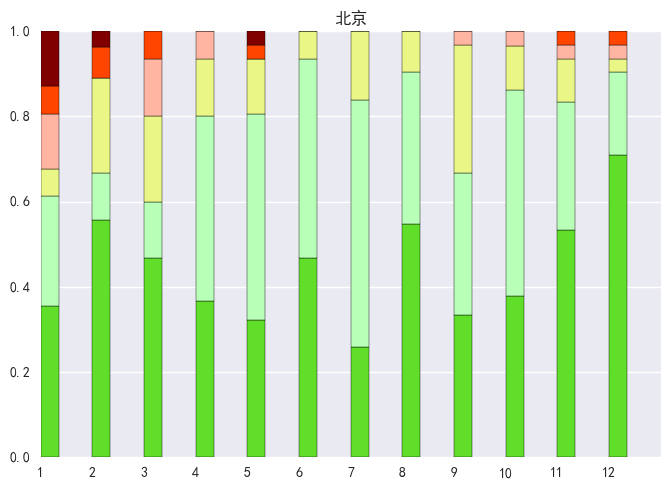

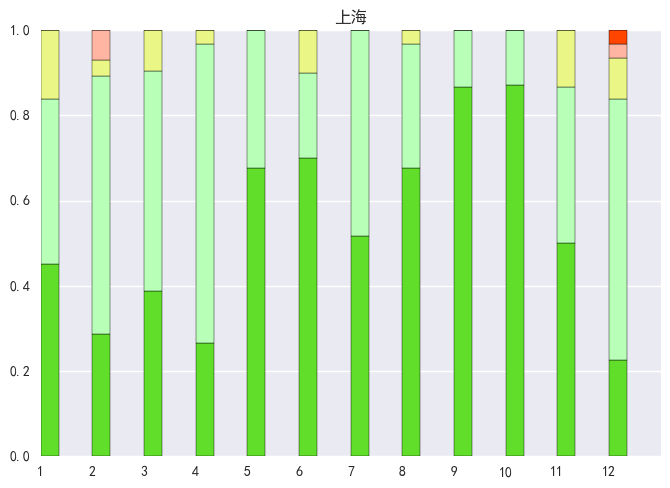

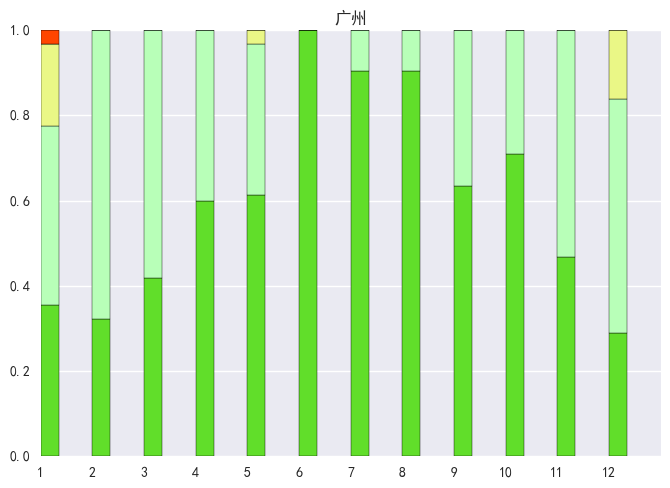

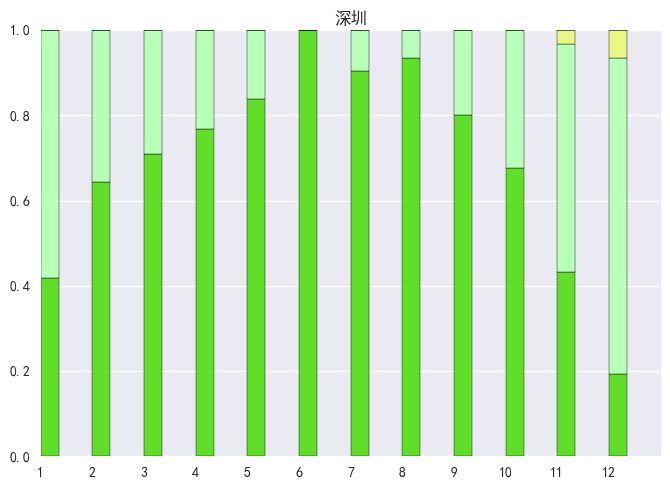

In [146]:
def city_stacked_bar(city):
    level1_list = [];level2_list = [];level3_list = [];level4_list = [];level5_list = [];level6_list = []
    data = stacked_data_for_drawing_data[1][city].iloc[:, 1]

    for i in range(len(stacked_data_for_drawing_data)):
        data = stacked_data_for_drawing_data[i][city].iloc[:, 1]
        level1 = np.where((data<= 35),1, 0)
        level1 = level1.sum()

        level2 = np.where((data>35)&(data <=75),1, 0)
        level2 = level2.sum()

        level3 = np.where((data>75)&(data <=115),1, 0)
        level3 = level3.sum()

        level4 = np.where((data>115)&(data <=150),1, 0)
        level4 = level4.sum()

        level5 = np.where((data>150)&(data <=250),1, 0)
        level5 = level5.sum()

        level6 = np.where((data>250),1, 0)
        level6 = level6.sum()

        level_S = level1+level2+level3+level4+level5+level6
        level1 = level1/level_S;level2 = level2/level_S;level3 = level3/level_S;level4 = level4/level_S;level5 = level5/level_S;level6 = level6/level_S
        level1_list.append(level1);level2_list.append(level2);level3_list.append(level3);level4_list.append(level4);level5_list.append(level5);level6_list.append(level6)
    level1_list = np.array(level1_list);level2_list = np.array(level2_list);level3_list = np.array(level3_list);level4_list = np.array(level4_list);level5_list = np.array(level5_list);level6_list = np.array(level6_list)
    return level1_list,level2_list,level3_list,level4_list,level5_list,level6_list,
def plot_pic(level_list):
    N = 12
    ind = np.arange(1,N+1)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, level_list[0], width,color = '#61de2a' )
    p2 = plt.bar(ind, level_list[1], width, bottom=level_list[0],color ='#b8ffb8')
    p3 = plt.bar(ind, level_list[2], width, bottom=level_list[0] + level_list[1],color = '#eaf786')
    p4 = plt.bar(ind, level_list[3], width, bottom=level_list[0] + level_list[1] + level_list[2],color = '#ffb5a1')
    p5 = plt.bar(ind, level_list[4], width, bottom=level_list[0] + level_list[1] + level_list[2] + level_list[3],color ='orangered')
    p6 = plt.bar(ind, level_list[5], width, bottom=level_list[0] + level_list[1] + level_list[2] + level_list[3] + level_list[4],color = 'maroon')
    plt.xlim([1,13]);plt.xticks(range(1,13))
plt.figure(1)
plt.title('北京')
data = city_stacked_bar('北京')
plot_pic(data)

plt.figure(2)
plt.title('上海')
data = city_stacked_bar('上海')
plot_pic(data)

plt.figure(3)
plt.title('广州')
data = city_stacked_bar('广州')
plot_pic(data)

plt.figure(4)
plt.title('深圳')
data = city_stacked_bar('深圳')
plot_pic(data)
plt.show()
